In [3]:
#Importando bibliotecas

import pandas as pd
import requests as req
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

A base de dados disponibiliza as seguintes informações sobre os títulos:

id - int\
title - string\
authors - lista de dicionários\
translators - lista\
subjects - lista de strings\
bookshelves - lista de strings\
languages - lista de strings \
copyright - booleano\
media_type - string\
formats - dicionário\
download_count - int

Para essa análise, os dados format, translators e subjects vão ser desconsiderados.

Pelo fato de authors, languages e bookshelves serem listas, serão criados 4 dataframes no total. Um para as informações dos livros e os outros 3 para os dados citados.

Então o primeiro passo é criar os dataframes. A API retorna no máximo 32 livros por pedido, assim, em vez de criar primeiro os dataframes e ir adicionando neles, serão usadas listas para acumular os dados para depois serem transformadas em dataframes, que é menos computacionalmente intensivo.

Como são 74276 títulos no total, seriam necessárias 2.322 pedidos, então, em vez de lidar com a base de dados toda, só serão usados os 11.200 títulos mais populares, o que ainda sim é uma quantidade considerável.

In [4]:
books = []
authors = []
bookshelves = []
languages = []

books_json = req.get("https://gutendex.com/books").json()
next_req = books_json["next"]
books_results = books_json["results"]
count = 0

while count < 350:
    for book in books_results:
        book_id = book["id"]
        books.append([book_id, book["title"], book["copyright"], book["media_type"], book["download_count"]])

        for author in book["authors"]:
            authors.append([book_id, author["name"], author["birth_year"], author["death_year"]])

        for bookshelf in book["bookshelves"]:
            bookshelves.append([book_id, bookshelf])

        for language in book["languages"]:
            languages.append([book_id, language])

    
    books_json = req.get(next_req).json()
    next_req = books_json["next"]
    books_results = books_json["results"]
    count += 1



In [5]:
df_books = pd.DataFrame(data = books, columns=["id", "title", "copyright", "media_type", "download_count"])
df_authors = pd.DataFrame(data = authors, columns=["id", "name", "birth_year", "death_year"])
df_bookshelves = pd.DataFrame(data = bookshelves, columns=["id", "bookshelf"])
df_languages = pd.DataFrame(data = languages, columns=["id", "language"])

Criados os dataframes, é possível passar para a etapa de análise dos dados. Para isso, é interessante entender o contexto do problema.

A API escolhida serve informações dos livros do catalogo do Projeto Gutenberg. Criado em 1971 na universidade de Illinois, o Projeto Gutenberg é uma biblioteca que disponibiliza de forma gratuita livros e textos pertencentes ao dominío público no formato digital.

In [6]:
# Função auxiliar para criar dataframes ordenados para itens com frequência maior que n. Se desejavel é possivel agregar os valores menores que n..
def df_more_than_n(df: pd.DataFrame, column_name: str, n: int, include_others: bool = True) -> pd.DataFrame:
    more_than_n = df[df[column_name] > n].sort_values(column_name, ascending = False).reset_index()
    if include_others:
        less_than_n = sum(df[df[column_name] < n].id)
        more_than_n = pd.concat([more_than_n, pd.DataFrame([["others", less_than_n]], columns = more_than_n.columns)], axis = 0)
    return more_than_n
    

<Axes: xlabel='language', ylabel='id'>

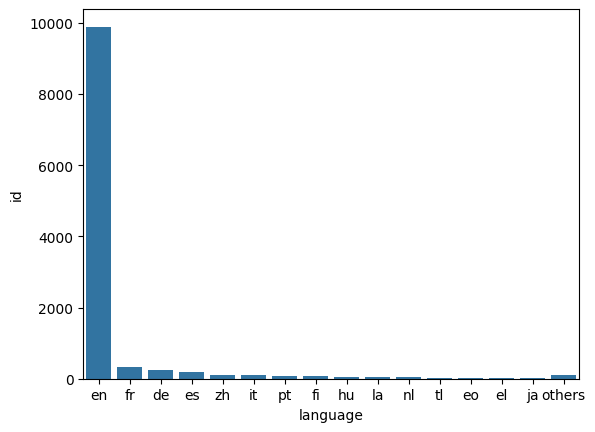

In [7]:
titles_per_language = df_languages.groupby("language").count()
sns.barplot(df_more_than_n(titles_per_language, "id", 10), x = "language", y ="id")

No gráfico é possível ver que o inglês é a principal linguangem dos títulos da biblioteca. Isso era de ser esperado, pelo fato do projeto ter começado nos Estados Unidos e seguir a legislação de copyrigth americana. Assim, deve ser mais difícil conseguir liberação para títulos traduzidos em outras línguas, já que possivelmente são registrados em outros países.

name
Kafka, Franz        25432
Hardy, Thomas        6024
Dickens, Charles     5080
Conrad, Joseph       4491
Twain, Mark          4127
Name: download_count, dtype: int64


<Axes: xlabel='copyright', ylabel='id'>

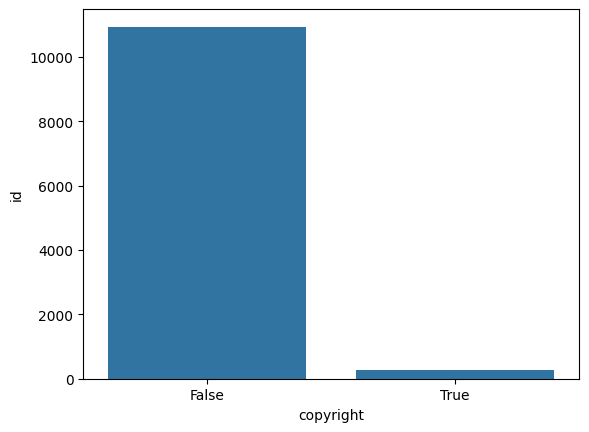

In [8]:
titles_per_copyright = df_books.groupby("copyright").count()

copyrighted_titles = pd.merge(df_books[df_books["copyright"]], df_authors, on = ["id"], how = "inner")

print(copyrighted_titles.groupby("name")["download_count"].sum().sort_values(ascending=False).head())
sns.barplot(titles_per_copyright, x = "copyright", y = "id")


<Axes: xlabel='media_type', ylabel='id'>

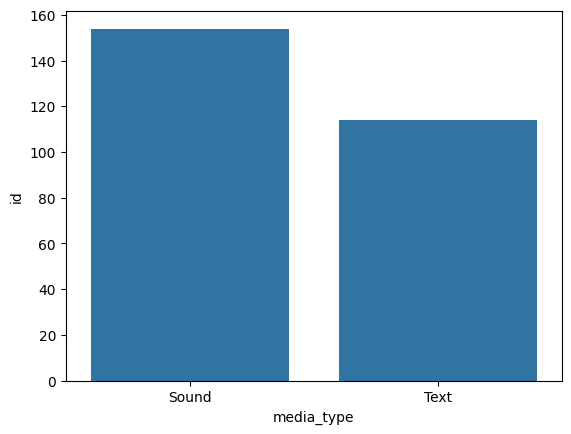

In [9]:
copyrighted_media_type = copyrighted_titles.groupby("media_type").count().reset_index()
sns.barplot(copyrighted_media_type, x = "media_type", y = "id")

No gráfico é possível notar a maioria dos trabalhos sendo do domínio público. Porém, alguns títulos com copyright vigente estão disponíveis devido a permissão dos autores, por exemplo, alguns títulos do autor alemão Franz Kafka têm copyright pelo motivo de serem traduções, apesar dos manuscritos originais serem de domínio público. Além disso, é interessante notar que a maioria dos trabalhos com copyright são no formato de áudio.

<Axes: xlabel='media_type', ylabel='id'>

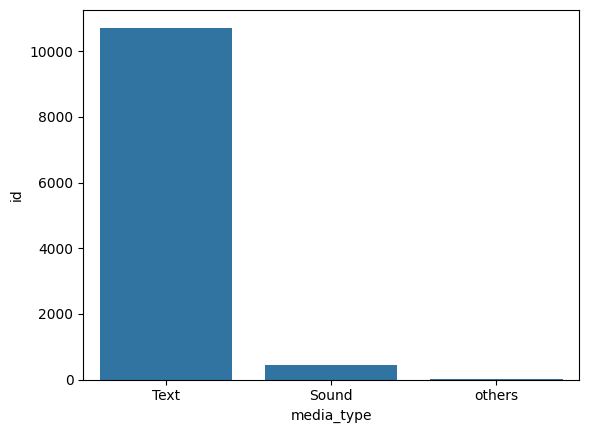

In [10]:
titles_by_media_type = df_books.loc[:, ["id", "media_type"]].groupby("media_type").count()
sns.barplot(df_more_than_n(titles_by_media_type, "id", 100), x = "media_type", y = "id")

Então é interessante notar que a maioria esmagadora dos títulos é em texto, o que é um constraste interessante em relação aos materiais com copyright.

       id                               bookshelf
23     84  Browsing: Culture/Civilization/Society
24     84                       Browsing: Fiction
25     84    Browsing: Gender & Sexuality Studies
26     84                    Browsing: Literature
27     84     Browsing: Science-Fiction & Fantasy
28     84                          Gothic Fiction
29     84                             Movie Books
30     84           Precursors of Science Fiction
31     84                Science Fiction by Women
104  2600                Best Books Ever Listings
105  2600                       Browsing: Fiction
106  2600            Browsing: History - European
107  2600             Browsing: History - Warfare
108  2600                    Browsing: Literature
109  2600                      Historical Fiction
110  2600                             Movie Books
111  2600                   Napoleonic(Bookshelf)
112  2600                                   Opera

      id                                    title

<Axes: xlabel='bookshelf', ylabel='count'>

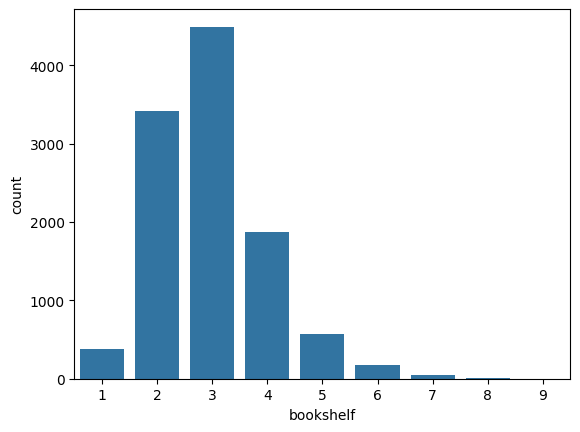

In [11]:
bookshelves_by_books = df_bookshelves.groupby("id").count()
most_bookshelfs = bookshelves_by_books.loc[bookshelves_by_books["bookshelf"] == bookshelves_by_books["bookshelf"].max()].index.tolist()

print(df_bookshelves.loc[df_bookshelves["id"].isin(most_bookshelfs)], end="\n\n")
print(df_books.loc[df_books["id"].isin(most_bookshelfs)][["id", "title"]])

counted_books_by_bookshelf = bookshelves_by_books.value_counts().sort_index().reset_index()
sns.barplot(counted_books_by_bookshelf, x = "bookshelf", y = "count")

Por fim, olhando para os eixos temáticos dos títulos, a maioria dos títulos se encaixa em 2 a 4 eixos, porém, dois títulos apresentam 9 classificações.

<Axes: xlabel='bookshelf', ylabel='id'>

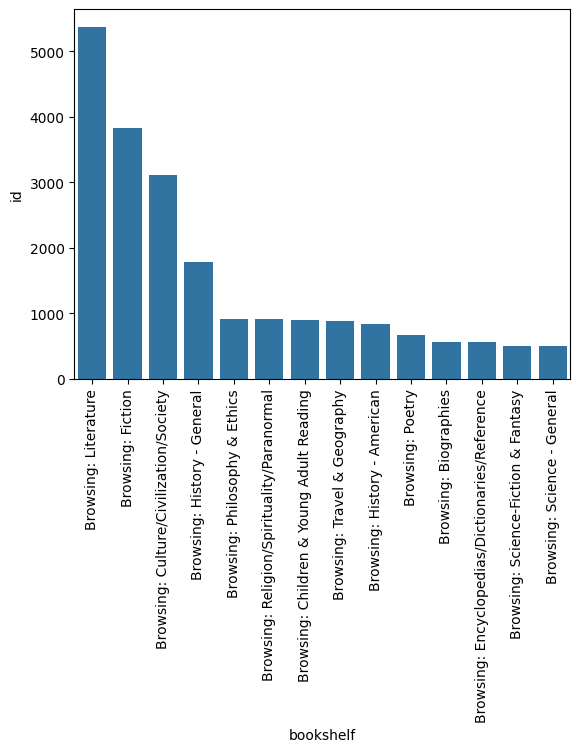

In [12]:
books_by_bookshelf = df_bookshelves.groupby("bookshelf").count().sort_values(by = "id", ascending=False)
plt.xticks(rotation=90)
sns.barplot(df_more_than_n(books_by_bookshelf, "id", 500, include_others = False), x = "bookshelf", y = "id")

Ainda sobre os eixos temáticos, o mais comuns é "literatura", que seriam livros considerados "clássicos", então é fácil entender o motivo de quase metade dos 11200 títulos mais populares de uma biblioteca onde a maior parte dos títulos é de domínio público se encaixaria nesse tema. Isso pode ser notado também ao analisar os dois títulos com mais classificações, "Guerra e Paz" e "Frankenstein", ambos são classificados como literatura, com certeza são livros clássicos, porém fora isso, são tematicamente bem diferentes.